# Nettoyage et selection des données

Après l'exploration des données nous allons mainteant sélectionné les données pour mener notre segmentation clients


In [1]:
import pandas as pd
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

## Création du jeux de données


In [2]:
# Connect to database SQLite
conn = sqlite3.connect('olist.db')

# Create a cursor for interact with database
cursor = conn.cursor()

In [3]:
df_clients_request = """
WITH last_purchase AS (
    SELECT
        MAX(order_purchase_timestamp) AS max_purchase_date
    FROM
        orders
    WHERE
        order_status = 'delivered'
),

recency AS (
    SELECT
        c.customer_unique_id,
        MAX(o.order_purchase_timestamp) AS last_purchase_date,
        ROUND(JULIANDAY((SELECT max_purchase_date FROM last_purchase)) - JULIANDAY(MAX(o.order_purchase_timestamp)), 0) AS recency
    FROM
        customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    WHERE
        o.order_status = 'delivered'
    GROUP BY
        c.customer_unique_id
),

frequency AS (
    SELECT 
        c.customer_unique_id, 
        COUNT(o.order_id) AS frequency  
    FROM 
        customers c  
    JOIN 
        orders o ON c.customer_id = o.customer_id  
    WHERE 
        o.order_status = 'delivered'  
    GROUP BY 
        c.customer_unique_id
),

monetary AS (
    SELECT 
        c.customer_unique_id,  
        SUM(oi.price) AS monetary  
    FROM 
        customers c  
    JOIN 
        orders o ON c.customer_id = o.customer_id  
    JOIN 
        order_items oi ON o.order_id = oi.order_id  
    WHERE 
        o.order_status = 'delivered'  
    GROUP BY 
        c.customer_unique_id
),

preferred_payment_type AS (
    SELECT
        c.customer_unique_id,
        op.payment_type,
        COUNT(*) as count
    FROM
        customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    JOIN 
        order_pymts op ON o.order_id = op.order_id  
    GROUP BY
        c.customer_unique_id, op.payment_type
),

preferred_payment_type_ranked AS (
    SELECT
        customer_unique_id,
        payment_type,
        ROW_NUMBER() OVER(PARTITION BY customer_unique_id ORDER BY count DESC) as rank
    FROM
        preferred_payment_type
),

day_with_most_orders AS (
    SELECT
        c.customer_unique_id,
        STRFTIME('%w', o.order_purchase_timestamp) AS day_of_week,
        COUNT(*) as count
    FROM
        customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    WHERE
        o.order_status = 'delivered'
    GROUP BY
        c.customer_unique_id, day_of_week
),

day_with_most_orders_ranked AS (
    SELECT
        customer_unique_id,
        day_of_week,
        ROW_NUMBER() OVER(PARTITION BY customer_unique_id ORDER BY count DESC) as rank
    FROM
        day_with_most_orders
),

preferred_product_category AS (
    SELECT
        c.customer_unique_id,
        t.product_category_name_english,
        SUM(oi.price) AS total_spent,
        COUNT(*) as count
    FROM
        customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    JOIN
        order_items oi ON o.order_id = oi.order_id
    JOIN
        products p ON oi.product_id = p.product_id
    JOIN
        translation t ON p.product_category_name = t.product_category_name
    WHERE
        o.order_status = 'delivered'
    GROUP BY
        c.customer_unique_id, t.product_category_name_english
),

preferred_product_category_ranked AS (
    SELECT
        customer_unique_id,
        product_category_name_english,
        ROW_NUMBER() OVER(PARTITION BY customer_unique_id ORDER BY total_spent DESC, count DESC) as rank
    FROM
        preferred_product_category
    GROUP BY
        customer_unique_id, product_category_name_english
)

SELECT
    r.customer_unique_id,
    r.recency,
    f.frequency,
    m.monetary,
    pp.payment_type AS preferred_payment_type,
    c.customer_city,
    c.customer_state,
    CASE
        WHEN dw.day_of_week = '0' THEN 'Dimanche'
        WHEN dw.day_of_week = '1' THEN 'Lundi'
        WHEN dw.day_of_week = '2' THEN 'Mardi'
        WHEN dw.day_of_week = '3' THEN 'Mercredi'
        WHEN dw.day_of_week = '4' THEN 'Jeudi'
        WHEN dw.day_of_week = '5' THEN 'Vendredi'
        WHEN dw.day_of_week = '6' THEN 'Samedi'
        ELSE 'Inconnu'
    END AS jour_avec_plus_de_commandes,
    pc.product_category_name_english AS catégorie_préférée
FROM
    recency r
JOIN
    frequency f ON r.customer_unique_id = f.customer_unique_id
JOIN
    monetary m ON r.customer_unique_id = m.customer_unique_id
JOIN
    customers c ON r.customer_unique_id = c.customer_unique_id
LEFT JOIN
    preferred_payment_type_ranked pp ON r.customer_unique_id = pp.customer_unique_id AND pp.rank = 1
LEFT JOIN
    day_with_most_orders_ranked dw ON r.customer_unique_id = dw.customer_unique_id AND dw.rank = 1
LEFT JOIN
    preferred_product_category_ranked pc ON r.customer_unique_id = pc.customer_unique_id AND pc.rank = 1
ORDER BY
    r.customer_unique_id;
"""


df_client = pd.read_sql_query(df_clients_request, conn)

# Exécution de la requête pour obtenir les dépenses par catégorie
df_spending_request = """
SELECT
    c.customer_unique_id,
    t.product_category_name_english,
    SUM(op.payment_value) AS total_spent
FROM
    customers c
JOIN
    orders o ON c.customer_id = o.customer_id
JOIN
    order_items oi ON o.order_id = oi.order_id
JOIN
    products p ON oi.product_id = p.product_id
JOIN
    translation t ON p.product_category_name = t.product_category_name
JOIN
    order_pymts op ON o.order_id = op.order_id
WHERE
    o.order_status = 'delivered'
GROUP BY
    c.customer_unique_id, t.product_category_name_english;
"""

df_spending = pd.read_sql_query(df_spending_request, conn)


# Pivot les dépenses par catégorie pour obtenir une colonne par catégorie
df_spending_pivot = df_spending.pivot(
    index='customer_unique_id', columns='product_category_name_english', values='total_spent').fillna(0)

# Renommer les colonnes en français pour les dépenses
df_spending_pivot.columns = [
    'dépense_' + col.replace(' ', '_').lower() for col in df_spending_pivot.columns]

# Fusionner les deux DataFrames
df_final = df_client.merge(
    df_spending_pivot, left_on='customer_unique_id', right_index=True, how='left')

# Renommer les colonnes en français
df_final = df_final.rename(columns={
    'customer_unique_id': 'identifiant_client',
    'recency': 'récence',
    'frequency': 'fréquence',
    'monetary': 'montant',
    'preferred_payment_type': 'type_de_paiement_préféré',
    'customer_city': 'ville_client',
    'customer_state': 'état_client',
    'jour_avec_plus_de_commandes': 'jour_avec_plus_de_commandes',
    'catégorie_préférée': 'catégorie_préférée'
})
display(df_final)

,identifiant_client,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_agro_industry_and_commerce,...,dépense_security_and_services,dépense_signaling_and_security,dépense_small_appliances,dépense_small_appliances_home_oven_and_coffee,dépense_sports_leisure,dépense_stationery,dépense_tablets_printing_image,dépense_telephony,dépense_toys,dépense_watches_gifts
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00
2,0000f46a3911fa3c0805444483337064,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,...,0.0,0.0,0.0,0.0,0.0,86.22,0.0,0.00,0.0,0.00
3,0000f6ccb0745a6a4b88665a16c9f078,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,43.62,0.0,0.00
4,0004aac84e0df4da2b147fca70cf8255,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,196.89,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96678,fffcf5a5ff07b0908bd4e2dbc735a684,447.0,1,1570.00,credit_card,sanharo,PE,Jeudi,health_beauty,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00
96679,fffea47cd6d3cc0a88bd621562a9d061,262.0,1,64.89,credit_card,feira de santana,BA,Dimanche,baby,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00
96680,ffff371b4d645b6ecea244b27531430a,568.0,1,89.90,credit_card,sinop,MT,Mardi,auto,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00
96681,ffff5962728ec6157033ef9805bacc48,119.0,1,115.00,credit_card,bom jesus do norte,ES,Mercredi,watches_gifts,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,133.69


## Nettoyage du jeu de donnée

### Vérification des données manquantes

In [4]:
# Verify missing values
missing_values = df_final.isnull().sum()
print(missing_values)

identifiant_client                   0
récence                              0
fréquence                            0
montant                              0
type_de_paiement_préféré             1
                                  ... 
dépense_stationery                1287
dépense_tablets_printing_image    1287
dépense_telephony                 1287
dépense_toys                      1287
dépense_watches_gifts             1287
Length: 80, dtype: int64


Nous avons des données manquantes sur les catégories. Nous allons dans un premier temps remplacer 'catégorie_préférée' par la valeur la plus fréquente et ensuite imputer le montant des dépenses à la catégorie qui a été remplacer avec la méthode most_fréquent.

In [5]:
# Find the most_frequent value in the column
most_frequent_categories = df_final['catégorie_préférée'].mode()[0]

# Get the most frequent values
print(f"catégorie la plus fréquente est : {most_frequent_categories}")
# replace fillna by most frequent values
df_final['catégorie_préférée'].fillna(most_frequent_categories, inplace=True)

catégorie la plus fréquente est : bed_bath_table


/tmp/ipykernel_128365/4290771616.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['catégorie_préférée'].fillna(most_frequent_categories, inplace=True)


In [6]:
# Identify columns starting with 'dépense'
depense_columns = [
    col for col in df_final.columns if col.startswith('dépense')]

# Replace missing values in 'dépense_bed_bath_table' with values from 'montant'
df_final['dépense_bed_bath_table'].fillna(df_final['montant'], inplace=True)

# Replace missing values in other 'dépense' columns with zero
for col in depense_columns:
    if col != 'dépense_bed_bath_table':
        df_final[col].fillna(0, inplace=True)

/tmp/ipykernel_128365/1602913787.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['dépense_bed_bath_table'].fillna(df_final['montant'], inplace=True)
/tmp/ipykernel_128365/1602913787.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m

In [7]:
# Drop rows with na values
df_final.dropna(inplace=True)
# Verify missing values
missing_values = df_final.isnull().sum()
print(missing_values)

identifiant_client                0
récence                           0
fréquence                         0
montant                           0
type_de_paiement_préféré          0
                                 ..
dépense_stationery                0
dépense_tablets_printing_image    0
dépense_telephony                 0
dépense_toys                      0
dépense_watches_gifts             0
Length: 80, dtype: int64


### Modification des catégories 

Nous allons regrouper les différentes catégories pour réduire les catégories représenter

In [8]:
# Maison
df_final['dépense_maison'] = (
    df_final['dépense_bed_bath_table'] +
    df_final['dépense_furniture_bedroom'] +
    df_final['dépense_furniture_decor'] +
    df_final['dépense_furniture_living_room'] +
    df_final['dépense_furniture_mattress_and_upholstery'] +
    df_final['dépense_housewares'] +
    df_final['dépense_home_confort'] +
    df_final['dépense_home_comfort_2'] +
    df_final['dépense_home_appliances'] +
    df_final['dépense_home_appliances_2']
)

# Électronique
df_final['dépense_électronique'] = (
    df_final['dépense_computers'] +
    df_final['dépense_computers_accessories'] +
    df_final['dépense_tablets_printing_image'] +
    df_final['dépense_telephony'] +
    df_final['dépense_fixed_telephony'] +
    df_final['dépense_electronics'] +
    df_final['dépense_audio'] +
    df_final['dépense_cine_photo']
)

# Mode
df_final['dépense_mode'] = (
    df_final['dépense_fashio_female_clothing'] +
    df_final['dépense_fashion_bags_accessories'] +
    df_final['dépense_fashion_childrens_clothes'] +
    df_final['dépense_fashion_male_clothing'] +
    df_final['dépense_fashion_shoes'] +
    df_final['dépense_fashion_sport'] +
    df_final['dépense_fashion_underwear_beach'] +
    df_final['dépense_luggage_accessories'] +
    df_final['dépense_watches_gifts']
)

# Loisirs et Divertissements
df_final['dépense_loisirs'] = (
    df_final['dépense_toys'] +
    df_final['dépense_sports_leisure'] +
    df_final['dépense_consoles_games'] +
    df_final['dépense_music'] +
    df_final['dépense_musical_instruments'] +
    df_final['dépense_party_supplies']
)

# Livres et Médias
df_final['dépense_médias'] = (
    df_final['dépense_books_general_interest'] +
    df_final['dépense_books_imported'] +
    df_final['dépense_books_technical'] +
    df_final['dépense_cds_dvds_musicals'] +
    df_final['dépense_dvds_blu_ray']
)

# Automobile et Outils
df_final['dépense_auto_outils'] = (
    df_final['dépense_auto'] +
    df_final['dépense_construction_tools_construction'] +
    df_final['dépense_construction_tools_lights'] +
    df_final['dépense_construction_tools_safety'] +
    df_final['dépense_costruction_tools_garden'] +
    df_final['dépense_costruction_tools_tools'] +
    df_final['dépense_garden_tools'] +
    df_final['dépense_air_conditioning']
)

# Santé et Beauté
df_final['dépense_santé_beauté'] = (
    df_final['dépense_health_beauty'] +
    df_final['dépense_perfumery'] +
    df_final['dépense_diapers_and_hygiene']
)

# Bébé et Enfant
df_final['dépense_bébé_enfant'] = (
    df_final['dépense_baby'] +
    df_final['dépense_diapers_and_hygiene']
)

# Cuisine et Restauration
df_final['dépense_cuisine'] = (
    df_final['dépense_food'] +
    df_final['dépense_food_drink'] +
    df_final['dépense_drinks'] +
    df_final['dépense_la_cuisine']
)

# Sécurité et Services
df_final['dépense_sécurité_services'] = (
    df_final['dépense_security_and_services'] +
    df_final['dépense_signaling_and_security']
)

# Drop ancient categories

delete_columns = [
    'dépense_agro_industry_and_commerce', 'dépense_air_conditioning', 'dépense_art',
    'dépense_arts_and_craftmanship', 'dépense_audio', 'dépense_auto', 'dépense_baby',
    'dépense_bed_bath_table', 'dépense_books_general_interest', 'dépense_books_imported',
    'dépense_books_technical', 'dépense_cds_dvds_musicals', 'dépense_christmas_supplies',
    'dépense_cine_photo', 'dépense_computers', 'dépense_computers_accessories',
    'dépense_consoles_games', 'dépense_construction_tools_construction', 'dépense_construction_tools_lights',
    'dépense_construction_tools_safety', 'dépense_cool_stuff', 'dépense_costruction_tools_garden',
    'dépense_costruction_tools_tools', 'dépense_diapers_and_hygiene', 'dépense_drinks',
    'dépense_dvds_blu_ray', 'dépense_electronics', 'dépense_fashio_female_clothing',
    'dépense_fashion_bags_accessories', 'dépense_fashion_childrens_clothes', 'dépense_fashion_male_clothing',
    'dépense_fashion_shoes', 'dépense_fashion_sport', 'dépense_fashion_underwear_beach',
    'dépense_fixed_telephony', 'dépense_flowers', 'dépense_food', 'dépense_food_drink',
    'dépense_furniture_bedroom', 'dépense_furniture_decor', 'dépense_furniture_living_room',
    'dépense_furniture_mattress_and_upholstery', 'dépense_garden_tools', 'dépense_health_beauty',
    'dépense_home_appliances', 'dépense_home_appliances_2', 'dépense_home_comfort_2',
    'dépense_home_confort', 'dépense_home_construction', 'dépense_housewares',
    'dépense_industry_commerce_and_business', 'dépense_kitchen_dining_laundry_garden_furniture',
    'dépense_la_cuisine', 'dépense_luggage_accessories', 'dépense_market_place', 'dépense_music',
    'dépense_musical_instruments', 'dépense_office_furniture', 'dépense_party_supplies',
    'dépense_perfumery', 'dépense_pet_shop', 'dépense_security_and_services',
    'dépense_signaling_and_security', 'dépense_small_appliances', 'dépense_small_appliances_home_oven_and_coffee',
    'dépense_sports_leisure', 'dépense_stationery', 'dépense_tablets_printing_image',
    'dépense_telephony', 'dépense_toys', 'dépense_watches_gifts'
]

# Suppression des colonnes
df_final.drop(columns=delete_columns, inplace=True)

In [9]:
display(df_final)

,identifiant_client,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,129.90,credit_card,cajamar,SP,Jeudi,bed_bath_table,141.9,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,18.90,credit_card,osasco,SP,Lundi,health_beauty,0.0,0.00,0.00,0.0,0.0,0.00,27.19,0.00,0.0,0.0
2,0000f46a3911fa3c0805444483337064,537.0,1,69.00,credit_card,sao jose,SC,Vendredi,stationery,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,321.0,1,25.99,credit_card,belem,PA,Jeudi,telephony,0.0,43.62,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,288.0,1,180.00,credit_card,sorocaba,SP,Mardi,telephony,0.0,196.89,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96678,fffcf5a5ff07b0908bd4e2dbc735a684,447.0,1,1570.00,credit_card,sanharo,PE,Jeudi,health_beauty,0.0,0.00,0.00,0.0,0.0,0.00,4134.84,0.00,0.0,0.0
96679,fffea47cd6d3cc0a88bd621562a9d061,262.0,1,64.89,credit_card,feira de santana,BA,Dimanche,baby,0.0,0.00,0.00,0.0,0.0,0.00,0.00,84.58,0.0,0.0
96680,ffff371b4d645b6ecea244b27531430a,568.0,1,89.90,credit_card,sinop,MT,Mardi,auto,0.0,0.00,0.00,0.0,0.0,112.46,0.00,0.00,0.0,0.0
96681,ffff5962728ec6157033ef9805bacc48,119.0,1,115.00,credit_card,bom jesus do norte,ES,Mercredi,watches_gifts,0.0,0.00,133.69,0.0,0.0,0.00,0.00,0.00,0.0,0.0


## Analyse des corrélations du jeu de données

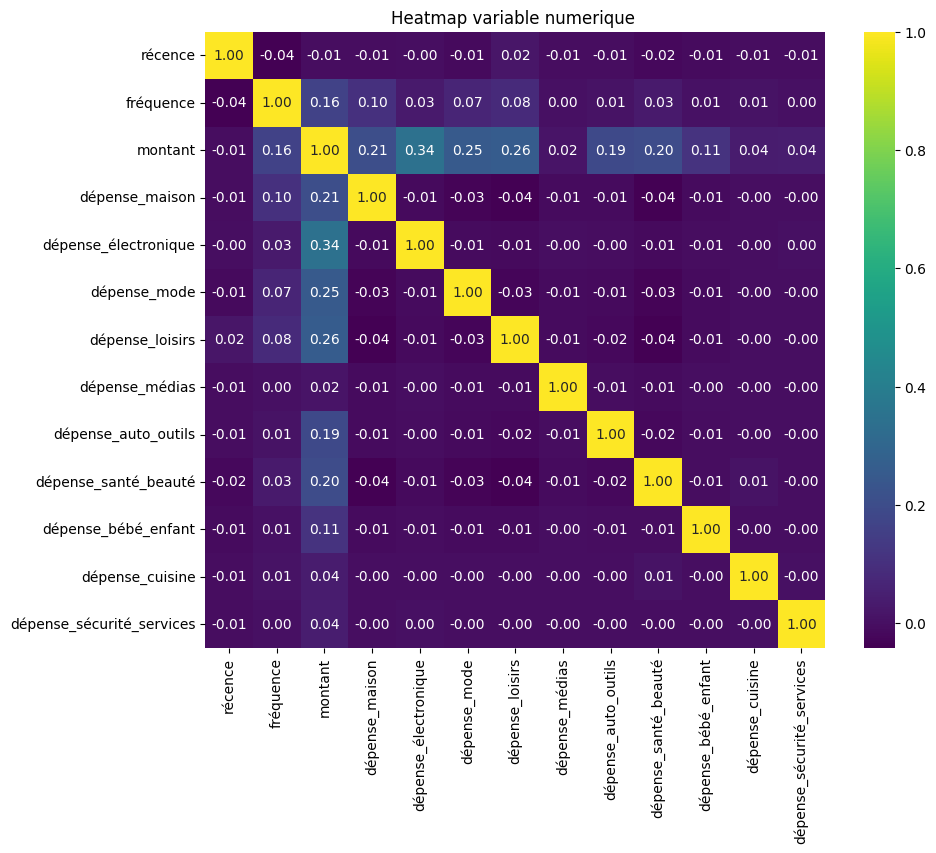

In [10]:
# Set 'identifiant_client' as the index
# df_final.set_index('identifiant_client', inplace=True)

# Filter the DataFrame to include only integer columns

df_numeric = df_final.select_dtypes(include=['int64', 'float64'])
# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()


# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap variable numerique ')
plt.show()

In [11]:
def remove_outliers_zscore(df, column, threshold=3):
    """
    Remove outliers based on Z-scores.

    Parameters:
    - df: DataFrame containing the data.
    - column: Column name to analyze.
    - threshold: Z-score threshold to define outliers (default is 3).

    Returns:
    - DataFrame with outliers removed.
    """
    # Calculer la moyenne et l'écart-type de la colonne
    mean = df[column].mean()
    std = df[column].std()

    # Calculer le Z-score pour chaque valeur
    z_scores = (df[column] - mean) / std

    # Filtrer les données pour supprimer les outliers
    df_out = df[np.abs(z_scores) <= threshold]
    return df_out


# Enregistrer le nombre de lignes avant la suppression des outliers
n_lignes_avant = df_final.shape[0]
# Enregistrer le nombre total de valeurs avant suppression
total_valeurs_avant = df_final.size

# Liste des colonnes numériques pour lesquelles détecter les outliers
numeric_columns = df_final.select_dtypes(include=['float64', 'int64']).columns

# Appliquer la suppression des outliers pour chaque colonne numérique
for col in numeric_columns:
    df_final = remove_outliers_zscore(df_final, col, threshold=3)

# Enregistrer le nombre de lignes après la suppression des outliers
n_lignes_apres = df_final.shape[0]
# Enregistrer le nombre total de valeurs après suppression
total_valeurs_apres = df_final.size

# Calcul du pourcentage de lignes supprimées
pourcentage_lignes_supprime = (
    (n_lignes_avant - n_lignes_apres) / n_lignes_avant) * 100

# Calcul du pourcentage du jeu de données supprimé
pourcentage_donnees_supprime = (
    (total_valeurs_avant - total_valeurs_apres) / total_valeurs_avant) * 100

print(f"Pourcentage du jeu de données supprimé : {
      pourcentage_donnees_supprime:.2f}%")

Pourcentage du jeu de données supprimé : 13.72%


In [12]:
# Select categorical and numerical columns
cat_cols = df_final.select_dtypes(include=['object']).columns
num_cols = df_final.select_dtypes(include=['float64', 'int64']).columns

# Encode categorical variables using frequency encoding
for col in cat_cols:
    freq_encoding = df_final[col].value_counts(normalize=True)
    df_final[col] = df_final[col].map(freq_encoding)

# Standardize numerical columns
scaler = StandardScaler()
df_final[num_cols] = scaler.fit_transform(df_final[num_cols])

# Now df is ready for K-Means
df_processed = df_final

In [13]:
display(df_processed)

,identifiant_client,récence,fréquence,montant,type_de_paiement_préféré,ville_client,état_client,jour_avec_plus_de_commandes,catégorie_préférée,dépense_maison,dépense_électronique,dépense_mode,dépense_loisirs,dépense_médias,dépense_auto_outils,dépense_santé_beauté,dépense_bébé_enfant,dépense_cuisine,dépense_sécurité_services
0,0.000012,-0.832885,-0.219759,0.399823,0.759213,0.001103,0.428085,0.146479,0.118584,1.236579,-0.323867,-0.268434,-0.337347,-0.062232,-0.265429,-0.312768,-0.125653,-0.080736,-0.014169
1,0.000012,-0.813170,-0.219759,-0.989381,0.759213,0.007672,0.428085,0.165444,0.084538,-0.460646,-0.323867,-0.268434,-0.337347,-0.062232,-0.265429,0.356631,-0.125653,-0.080736,-0.014169
2,0.000012,1.966683,-0.219759,-0.362362,0.759213,0.001690,0.036467,0.138615,0.026973,-0.460646,-0.323867,-0.268434,-0.337347,-0.062232,-0.265429,-0.312768,-0.125653,-0.080736,-0.014169
3,0.000012,0.547183,-0.219759,-0.900648,0.759213,0.004028,0.008871,0.146479,0.045817,-0.460646,0.665948,-0.268434,-0.337347,-0.062232,-0.265429,-0.312768,-0.125653,-0.080736,-0.014169
4,0.000012,0.330315,-0.219759,1.026842,0.759213,0.006485,0.428085,0.162255,0.045817,-0.460646,4.143915,-0.268434,-0.337347,-0.062232,-0.265429,-0.312768,-0.125653,-0.080736,-0.014169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96677,0.000012,0.047730,-0.219759,0.638866,0.759213,0.006174,0.012311,0.155314,0.118584,1.321500,-0.323867,-0.268434,-0.337347,-0.062232,-0.265429,-0.312768,-0.125653,-0.080736,-0.014169
96679,0.000012,0.159450,-0.219759,-0.413800,0.759213,0.001798,0.032919,0.124877,0.016100,-0.460646,-0.323867,-0.268434,-0.337347,-0.062232,-0.265429,-0.312768,9.254652,-0.080736,-0.014169
96680,0.000012,2.170407,-0.219759,-0.100791,0.759213,0.000396,0.008703,0.162255,0.039428,-0.460646,-0.323867,-0.268434,-0.337347,-0.062232,2.370072,-0.312768,-0.125653,-0.080736,-0.014169
96681,0.000012,-0.780311,-0.219759,0.213344,0.759213,0.000036,0.020631,0.155314,0.048623,-0.460646,-0.323867,3.374392,-0.337347,-0.062232,-0.265429,-0.312768,-0.125653,-0.080736,-0.014169
